In [1]:
import io

import dicomweb_client.api
import highdicom.content
import highdicom.seg.content
import highdicom.seg.sop
import highdicom.uid
import highdicom.version
import matplotlib.pyplot
import numpy
import pydicom.dataset
import pydicom.sr.codedict
import PIL.Image
import torch.utils.data

### Implement a custom pytoch Dataset to load image frames from a remote DICOM VL Whole Slide Microscopy Image instance

In [2]:
class Dataset(torch.utils.data.Dataset):
    
    """Class for getting individual Pixel Data element frame items of a DICOM VL Whole Slide Microscocpy Image data set stored on a remote server."""

    def __init__(self, url: str, study_id: str, series_id: str, instance_id: str):
        """
        Parameters
        ----------
        url: str
            Address of a DICOMweb origin server
        study_id: str
            Study Instance UID
        series_id: str
            Seriess Instance UID of a Slide Microscopy series
        instance_id: str
            SOP Instance UID of a VL Whole Slide Microscopy Image instance
        """
        self.client = dicomweb_client.api.DICOMwebClient(url)
        metadata = self.client.retrieve_instance_metadata(
            study_instance_uid=study_id,
            series_instance_uid=series_id,
            sop_instance_uid=instance_id
        )
        self.meta = pydicom.dataset.Dataset.from_json(metadata)

    def __len__(self) -> int:
        """int: number of frames"""
        return int(self.meta.NumberOfFrames)

    def __getitem__(self, idx: int) -> numpy.ndarray:
        """Retrieves an invidivual frame.
        
        Parameters
        ----------
        idx: int
            Zero-based frame index
            
        Returns
        -------
        numpy.ndarray
            Pixels of the frame
            
        """
        frames = self.client.retrieve_instance_frames(
            study_instance_uid=self.meta.StudyInstanceUID,
            series_instance_uid=self.meta.SeriesInstanceUID,
            sop_instance_uid=self.meta.SOPInstanceUID,
            frame_numbers=[idx+1],
            media_types=('image/jpeg', 'image/jp2', )
        )
        buf = io.BytesIO(frames[0])
        return numpy.array(PIL.Image.open(buf))

### Implement a simple binary image segmentation model

In [3]:
def model(image: numpy.ndarray) -> numpy.ndarray:
    """Segments a microscopy image into regions representing tissue foreground and slide background.
    
    Parameters
    ----------
    image: numpy.ndarray
        Pixel matrix of an image or image frame
        
    Returns
    -------
    numpy.ndarray
        Binary mask where tissue foreground is ``True`` and slide background is ``False``
    
    """
    return numpy.max(image < 225, 2).astype(numpy.bool)

### Instantiate the Dataset, pass inputs to the model and receive back outputs in form of NumPy arrays

In [4]:
dataset = Dataset(
    url='https://server.dcmjs.org/dcm4chee-arc/aets/DCM4CHEE/rs',
    study_id='1.2.392.200140.2.1.1.1.2.799008771.3960.1519719403.819',
    series_id='1.2.392.200140.2.1.1.1.3.799008771.3960.1519719403.820',
    instance_id='1.2.392.200140.2.1.1.1.4.799008771.3960.1519719570.834'
)

inputs = []
outputs = []
for i in range(len(dataset)):
    image_frame = dataset[i]
    mask_frame = model(image_frame)
    inputs.append(image_frame)
    outputs.append(mask_frame)

image = numpy.stack(inputs)
mask = numpy.stack(outputs)

/usr/local/lib/python3.8/site-packages/pydicom/jsonrep.py:128: UserWarning: no bulk data URI handler provided for retrieval of value of data element "00282000"
  warnings.warn(
/usr/local/lib/python3.8/site-packages/pydicom/jsonrep.py:128: UserWarning: no bulk data URI handler provided for retrieval of value of data element "7FE00010"
  warnings.warn(


In [5]:
print('Expected input shape  : ', (int(dataset.meta.NumberOfFrames), dataset.meta.Rows, dataset.meta.Columns, dataset.meta.SamplesPerPixel))
print('Actual input shape    : ', image.shape)
print('Expected output shape : ', (int(dataset.meta.NumberOfFrames), dataset.meta.Rows, dataset.meta.Columns))
print('Actual ouput shape    : ', mask.shape)

Expected input shape  :  (25, 512, 512, 3)
Actual input shape    :  (25, 512, 512, 3)
Expected output shape :  (25, 512, 512)
Actual ouput shape    :  (25, 512, 512)


### Plot an overview of model inputs and outputs

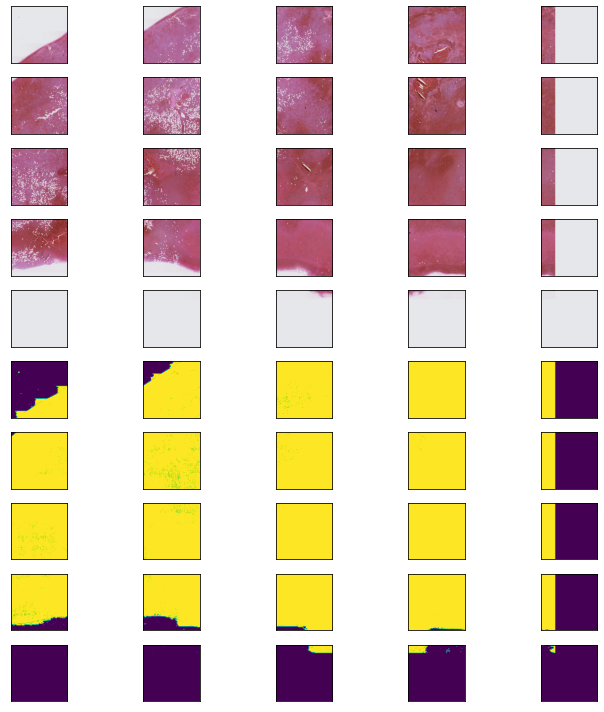

In [6]:
fig, axs = matplotlib.pyplot.subplots(
    nrows=10,
    ncols=len(dataset) // 5,
    figsize=(10, 10),
    subplot_kw={'xticks': [], 'yticks': []}
)
for i, ax in enumerate(axs.flat[:(len(axs.flat) // 2)]):
    ax.imshow(image[i])
for i, ax in enumerate(axs.flat[(len(axs.flat) // 2):]):
    ax.imshow(mask[i].astype(numpy.uint8) * 255)
    
matplotlib.pyplot.tight_layout()

### Encode model outputs in form of a DICOM Segmentation instance

In [7]:
algorithm = highdicom.content.AlgorithmIdentificationSequence(
    name='Binary Image Segmentation Example',
    family=pydicom.sr.codedict.codes.cid7162.ArtificialIntelligence,
    version='v0.1.0'
)

segment_description = highdicom.seg.content.SegmentDescription(
    segment_number=1,
    segment_label='ROI #1',
    segmented_property_category=pydicom.sr.codedict.codes.cid7150.Tissue,
    segmented_property_type=pydicom.sr.codedict.codes.SCT.BodyFat,
    algorithm_type=highdicom.seg.enum.SegmentAlgorithmTypeValues.AUTOMATIC,
    algorithm_identification=algorithm
)

segmentation = highdicom.seg.sop.Segmentation(
    source_images=[dataset.meta],
    pixel_array=mask,
    segmentation_type=highdicom.seg.enum.SegmentationTypeValues.FRACTIONAL,
    segment_descriptions=[segment_description],
    series_instance_uid=highdicom.uid.UID(),
    series_number=2,
    sop_instance_uid=highdicom.uid.UID(),
    instance_number=1,
    manufacturer='MGH Computational Pathology',
    manufacturer_model_name='Example Jupyter Notebook',
    software_versions=highdicom.version.__version__,
    device_serial_number='XXX'
)

In [8]:
print(segmentation)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 222
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.511.3.97954594932704450884108828533582337
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.9.7433.1.1
(0002, 0013) Implementation Version Name         SH: 'highdicom v0.4.1'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Segmentation Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10.511.3.97954594932704450884108828533582337
(0008, 0020) Study Date                          DA: '20180227'
(0008, 0023) Conten